<a href="https://colab.research.google.com/github/weathon/slay/blob/main/SlayTree_vs_OldCMT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
import pylab
import numpy as np

In [92]:
import numpy as np
import pandas as pd 
import random
import pylab 
import multiprocessing
import time
from pyrsistent import l
import timeit

def ifNone(a):
    if type(a) == type(None):
        return True
    else:
        return False

def maxPerArg(list1, list2):
    if len(list1) != len(list2):
        raise Exception("OOBA %s,%s" % (len(list1), len(list2)))
    ans = list1[:]
    for i in range(len(list1)):
        if list2[i]>list1[i]:
            ans[i] = list2[i]
    return ans

def minPerArg(list1, list2):
    if len(list1) != len(list2):
        raise Exception("OOBA %s,%s" % (len(list1), len(list2)))
    ans = list1[:]
    for i in range(len(list1)):
        if list2[i]<list1[i]:
            ans[i] = list2[i]
    return ans

class dataPoint:
    def __init__(self, d, id):
        self.data = d
        self.id = id
        self.ancestorsDistances = {}
        self.ancestorsDistancesList = []
        self.distanceFromDad = -1
        self.max = -1
        self.min = -1
        self.fars = [-1]
        self.nears = [-1]
    def __str__(self):
        return str(self.data)

def randomArray(size):
    ans = []
    for i in range(size):
        ans.append(random.random())
    return np.array(ans)



class BallTreeNode:
  def __init__(self):
    self.myobject = None
    self.inner = None
    self.outer = None
    self.left = None
    self.right = None
    self.count = 0

def getData(myArray):
    myArray.sort(key=lambda x: x.distanceFromDad)
    theMax = myArray[-1].distanceFromDad
    theMin = myArray[0].distanceFromDad
    inner = myArray[int(len(myArray)/2)-1].distanceFromDad
    outer = myArray[int(len(myArray)/2)].distanceFromDad
    return theMax, theMin, inner, outer, myArray


counts = 0
def d(a, b, r=0):
  global counts
  a, b = a.data, b.data
  counts+=1
  return np.sqrt(np.sum((a-b)**2))


def ConstructBallTree(BT, localobjects):
  if len(localobjects)==0:
    return BT
  if len(localobjects)==1:
    BT.myobject = localobjects[0]
    BT.inner = 0
    BT.outer = 0
    BT.count = 1
    return BT
  selectedIndex = random.randint(0,len(localobjects)-1)
  localobjects[-1], localobjects[selectedIndex] = localobjects[selectedIndex], localobjects[-1] 
  BT.myobject = localobjects[-1]
  localobjects = localobjects[:-1]
  
  
  for i in range(len(localobjects)):
    localobjects[i].distanceFromDad=d(BT.myobject, localobjects[i])
    localobjects[i].ancestorsDistancesList.append(localobjects[i].distanceFromDad)
  
  BT.myobject.max, BT.myobject.min, BT.inner, BT.outer, sortedlocalobjects = getData(localobjects)

  
  

  L = []
  R = []
  for i in range(len(localobjects)):
    if localobjects[i].distanceFromDad<=BT.inner:
      L.append(localobjects[i])
    elif localobjects[i].distanceFromDad>=BT.outer:
      R.append(localobjects[i])
    else:
      print("where am i", BT.inner,BT.outer)

  BT.count = len(localobjects)

  if len(L) != 0:
    BT.left = ConstructBallTree(BallTreeNode(),L)
  if len(R) != 0:
    BT.right = ConstructBallTree(BallTreeNode(),R)
  
  

  return BT


def generateCMTData(BT):
    if ifNone(BT):
        return [], []
    Lnear, Lfar = generateCMTData(BT.left)
    Rnear, Rfar = generateCMTData(BT.right)
    Lnear, Lfar, Rnear, Rfar = Lnear[:-1], Lfar[:-1], Rnear[:-1], Rfar[:-1]
    
    if len(Lnear) != 0 and len(Rnear) != 0:
        
        BT.myobject.nears = minPerArg(minPerArg(Lnear, Rnear), BT.myobject.ancestorsDistancesList)
        BT.myobject.fars = maxPerArg(maxPerArg(Lfar, Rfar), BT.myobject.ancestorsDistancesList)
    elif len(Lnear) != 0:
        
        BT.myobject.nears = minPerArg(Lnear, BT.myobject.ancestorsDistancesList)
        BT.myobject.fars = maxPerArg(Lfar, BT.myobject.ancestorsDistancesList)
    elif len(Rnear) != 0:
        
        BT.myobject.nears = minPerArg(Rnear, BT.myobject.ancestorsDistancesList)
        BT.myobject.fars = maxPerArg(Rfar, BT.myobject.ancestorsDistancesList)
    elif len(Rnear) == 0 and len(Lnear) == 0:
    
        
        BT.myobject.nears = BT.myobject.ancestorsDistancesList
        BT.myobject.fars = BT.myobject.ancestorsDistancesList 
        
        
        
    
    
    returnNear = BT.myobject.nears
    returnFar = BT.myobject.fars

    return returnNear, returnFar
    



def maxPD(stack, node): 
    nears = node.myobject.nears
    fars = node.myobject.fars
    if len(stack) != len(fars):
        
        raise Exception("stack and fars not match %s, %s" %(len(stack), len(fars)))
    maxPDV = 0
    for i in range(len(stack)):
        
        if fars[i] < stack[i]:
            
            maxPDV = max(maxPDV, stack[i] - fars[i]) 
        elif nears[i] > stack[i]:
            maxPDV = max(maxPDV, nears[i] - stack[i])
    # print(maxPDV)
    return maxPDV
        

def CMTSearchRadius(BT, Object, r, ans):
  global stack
  if BT == None:
    return

  maxPDV = maxPD(stack, BT) 
      
  if maxPDV > r:
    return
    
  dis = d(Object, BT.myobject, r)
    
  if dis <= r:
    ans.append(BT.myobject)  

  if type(BT.myobject.max) != type(None):
    if dis > BT.myobject.max:
      if dis - BT.myobject.max > r: 
        return

  if type(BT.myobject.min) != type(None):
    if dis < BT.myobject.min:
      if BT.myobject.min - dis > r:
        return  
  
  stack.append(dis)
  if dis + r >= BT.outer:
    CMTSearchRadius(BT.right, Object, r, ans)
  if BT.inner >= dis - r:                              
    CMTSearchRadius(BT.left, Object, r, ans)
  stack.pop()

In [93]:
Objects = []
for i in range(10000):
  tmp = dataPoint(randomArray(5), i)
  Objects.append(tmp)


counts = 0
begin = time.time()
NewBT = ConstructBallTree(BallTreeNode(),Objects)
end = time.time()
print("Construction time:", (end-begin)*1000)

begin = time.time()
generateCMTData(NewBT)
end = time.time()
print("CMT Data time:", (end-begin)*1000)


Construction time: 1619.6706295013428
CMT Data time: 71.49791717529297


In [94]:
class TreeNode:
  def __init__(self, objectA, objectB):
    self.objectA = objectA
    self.objectB = objectB
    if not objectB is None and not objectA is None:
      self.halfway = d(objectA, objectB)
    self.left = None
    self.right = None
  
  def __str__(self):
    return str((self.objectA, self.objectB))

In [95]:
def buildTree(objects):
  if len(objects)==0:
    return None
  if len(objects) == 1:
    root = TreeNode(objects[0], None)
    return root
  elif len(objects) == 2:
    root = TreeNode(objects[0], objects[1])
    return root

  center1 = 0 #why default 50??
  center2 = -1

  maxD = -1

  for i in range(len(objects)):
    dis = d(objects[i], objects[center1])
    if dis>maxD:
      maxD=dis
      center2=i
    
  maxD = -1

  for i in range(len(objects)):
    dis = d(objects[i], objects[center2])
    if dis>maxD:
      maxD=dis
      center1=i
  # print(center1, center2, len(objects))
  root = TreeNode(objects[center1], objects[center2])

  del objects[center1]
  if center1<center2:
     del objects[center2-1] #opmization needed
  else:
    del objects[center2] 
  # I got it center1 and 2 are not indexes!!! mix index and ID again
  left = []
  right = []

  for i in objects:
    if d(i, root.objectA) < d(i, root.objectB):
      left.append(i)
    else:
      right.append(i)

  # print(len(left),len(right),len(objects))
  # if root.objectA in left:
  # # if root.objectA in left: wtf not in objects but in left? oh i got it it is range objects i got it
  #   print("WTF")
  root.left = buildTree(left)
  root.right = buildTree(right)
  return root

In [96]:
def searchBF(objects, id, r):
  ans = []
  for i in objects:
    if d(id, i)<=r:
      ans.append(i)
  return ans

In [97]:
def searchTree(root, id, r, ans):
  if root == None: #empty, since it is not inited
    return
  if root.objectB == None:
    dA = d(root.objectA, id)
    if dA<=r:
      ans.append(root.objectA)
    return

  dA = d(root.objectA, id)
  dB = d(root.objectB, id)
  if dA<=r:
    ans.append(root.objectA)
  if dB <= r:
    ans.append(root.objectB)

  # halfway = d(root.objectA, root.objectB) #(could be precomputed)
  
  if dA-r<=dB+r: 
    searchTree(root.left,id,r, ans)
  if dB-r<=dA+r: 
    searchTree(root.right,id,r, ans)

In [111]:
# objectSets = []
# for i in range(10000):
#   tmp = dataPoint([random.random(), random.random()], i)

objectSets = []
for i in range(100_000):
  tmp = dataPoint(randomArray(5), i)
  objectSets.append(tmp)


counts = 0

slaytree = buildTree(objectSets)
CMT = ConstructBallTree(BallTreeNode(), objectSets)
generateCMTData(CMT)

([], [])

In [112]:
def BaselineSearchRadius(BT, Object, r, ans):
  if BT == None:
    return
  dis = d(Object, BT.myobject, r)
  if dis <= r:
    ans.append(BT.myobject)
  

  if type(BT.myobject.max) != type(None):
    if dis > BT.myobject.max:
      if dis - BT.myobject.max > r: 
        return

  if type(BT.myobject.min) != type(None):
    if dis < BT.myobject.min:
      if BT.myobject.min - dis > r:
        return  
  
  
  
  if dis + r >= BT.outer:
    BaselineSearchRadius(BT.right, Object, r, ans)
  if BT.inner >= dis - r:                              
    BaselineSearchRadius(BT.left, Object, r, ans)


In [ ]:
a = []
b = []
target = 50
for r in np.arange(0,1,0.1):
  ans1 = searchBF(objectSets, objectSets[target], r)
  ans2 = []
  counts = 0
  searchTree(slaytree, objectSets[target], r, ans2)
  ans3 = []
  stack =[]
  counts1 = counts
  counts = 0
  BaselineSearchRadius(CMT, objectSets[target], r, ans3) #even baseline is better
  counts2 = counts
  # print(len(ans1), len(ans2), len(ans3))
  # print(counts1, counts2) #so nervous kunyunexkunyun
  a.append(counts1)
  b.append(counts2)

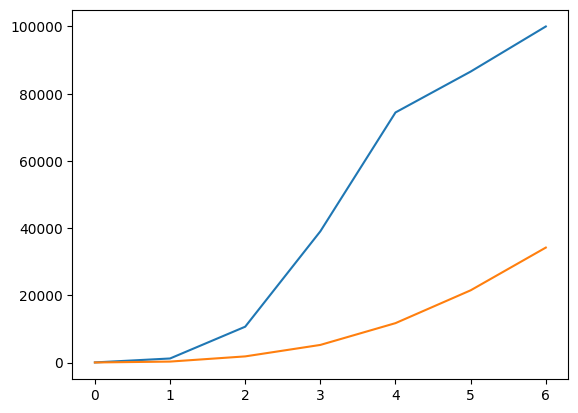

In [117]:
pylab.plot(a)
pylab.plot(b)